# Instruction to lab work # 1

> Student name    - Dmytro

> Student surname - Honcharuk

> Group           - KS-32


# Task description

### Overall work description

The work will contain 2 main parts:
1. In the first part you'll build intuition behind using various regression models using only artificially generated (with noise & outliers) data. I've generated 2 options with `f(x) = A*sin(x) + B` and `f(x) = a*x + b` functions. (you free to add more complex functions (even more dimensional).
2. In the second part you'll solve regression problem on the real data.

Do NOT forget to change your `STUDENT_NO` -- this variable defines random state (it just makes experimental data for every one slighty different).

Do NOT forget to set you contact data in the top cell.


### I. Experiments on artificially generated data:

1. Manually tune linear model by changing `a` and `b` weights of it. Observe position of the line and values of loss function.
2. **More advanced task** (+2 point): modify my code to work with more complex functions as regression models (linear, polynomial, sin, cos, and their combination). Feel free to use as complex function as you could found. Generate some random non-linear data and use your function to manually adjust its weights.
3. Play with default regression methods from `sklearn` library on non-linear data. Search, llm-prompt information on each model to understand how to make the model fit the data without overfitting.


### II. Experiments on real data. (you can keep it in this notebook or in a separate one).

1. Choose any DataSet you like for you experiments (if you've chosen the same, consider that work must differ, otherwise both students will get 0 points for work).
2. Choose the top-3 methods (from `sklearn` library, or you can use other libraries (like `xgboost`) from the previous part.
2. Solve the regression problem in the same manner, as you used for.
    1. Load the data
    2. Do data visualization: correlation, feature distribution, etc.
    3. Do data analysis
    4. Do data correction
    5. Prepare data on usage with ML model: train, validation if necessary, test split; data convertion (to fix distribution or change data type to numeric); remove outliers.
    6. Tune hyperparameters of your model to get the best one.
    7. Train & test the final version of the model. Do conclusion.
3. Your main goal is tune hyperparameters of the chosen models.
4. Examples and template you can find in `ML_basic_course/lab_works/lab2/lab_2_example_plus_task.ipynb`. Or in [my GitHub repo's folder](https://github.com/VolDonets/ML_basics_course/tree/master/lab_works/lab_2)
5. Use that notebook as template, but remember your main goal is to tune hyperparameters of chosen models.

### III. Important.

1. Students, who solved the problem in a single code cell will get 0 points for your work. It's hard to work with your messy code, we have limited time. Use this notebook as your template, create as many cells as you need. Also you can conduct experiments in .py files but in that case prepare normal report.
2. Experiments means you have multiple cells with EXPERIMENTS and your CONCLUSION after that.
3. You can have multiple notebooks if you need, but name it correctly and add `ReadMe.md`.


## Proposition of the real data for experiments


7. [California House Price](https://www.kaggle.com/datasets/shibumohapatra/house-price)


In [12]:
STUDENT_NO = 7
DATA_PATH = "housing.csv"

# Import dependencies

In [3]:

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Helping functions

In [50]:
def generate_regression_data(
    n_samples=50, 
    n_features=1, 
    mode='linear', 
    noise=2.0, 
    n_outliers=5, 
    random_seed=42, 
    return_coef=False
):
    rng = np.random.RandomState(random_seed)
    X = rng.rand(n_samples, n_features) * 10 - 5
    true_intercept = 0.0
    true_weights = np.zeros(n_features)
    if mode == 'linear':
        true_intercept = rng.uniform(-3, 3)
        true_weights = rng.uniform(-5, 5, size=n_features)
        y_true = np.dot(X, true_weights) + true_intercept
    elif mode == 'nonlinear':
        if n_features < 1:
            raise ValueError("Nonlinear mode requires at least 1 feature.")
        true_intercept = rng.uniform(-15, 15)
        true_weights = rng.uniform(-5, 5, size=n_features)
        y_true = true_weights[0] * 20 * np.sin(X[:, 0]*1.5) + true_intercept
        if n_features > 1:
            y_true += np.dot(X[:, 1:], true_weights[1:])
    else:
        raise ValueError("Mode must be either 'linear' or 'nonlinear'")

    y = y_true + rng.normal(scale=noise, size=n_samples)

    if n_outliers > 0:
        outlier_indices = rng.choice(n_samples, n_outliers, replace=False)
        outlier_offset = (rng.rand(n_outliers) - 0.5) * 30 * (noise + 1)
        y[outlier_indices] += outlier_offset

    if return_coef:
        return X, y, {'weights': true_weights, 'intercept': true_intercept}
    return X, y



In [51]:
def plot_regression_model(
    X, 
    y, 
    weights=None,
    intercept=None, 
    title="Regression Model Visualization",
):
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    n_features = X.shape[1]
    model_provided = (weights is not None) and (intercept is not None)

    fig, ax = plt.subplots(figsize=(9, 6))

    if n_features == 1:
        ax.scatter(X[:, 0], y, alpha=0.7, label='Data')
        if model_provided:
            x_line = np.linspace(X[:, 0].min(), X[:, 0].max(), 300)
            y_line = x_line * weights[0] + intercept
            ax.plot(x_line, y_line, linewidth=2.0, label=f"y = {weights[0]:.2f}x + {intercept:.2f}")
        ax.set_xlabel("Feature (X)")
        ax.set_ylabel("Target (y)")
    else:
        if not model_provided:
            print("Provide weights & intercept for multi-feature plot.")
            plt.close(fig)
            return
        y_pred = np.dot(X, weights) + intercept
        ax.scatter(y, y_pred, alpha=0.7)
        lo = min(y.min(), y_pred.min())
        hi = max(y.max(), y_pred.max())
        ax.plot([lo, hi], [lo, hi], linestyle='--', linewidth=2.0, label='Perfect Fit')
        ax.set_xlabel("Actual (y)")
        ax.set_ylabel("Predicted (ŷ)")

    ax.set_title(title)
    ax.legend()
    plt.show()


In [52]:
def plot_sklearn_regression(model, X, y, title="Model Performance", step=0.01):
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n_features = X.shape[1]
    fig, ax = plt.subplots(figsize=(9, 6))

    if n_features == 1:
        ax.scatter(X[:, 0], y, alpha=0.6, label='Actual')
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        padding = (x_max - x_min) * 0.05
        x_line = np.arange(x_min - padding, x_max + padding, step).reshape(-1, 1)
        y_line = model.predict(x_line)
        ax.plot(x_line[:, 0], y_line, linewidth=2.0, label='Model')
        ax.set_xlabel("Feature (X)")
        ax.set_ylabel("Target (y)")
    else:
        y_pred = model.predict(X)
        ax.scatter(y, y_pred, alpha=0.6)
        lo = min(y.min(), y_pred.min())
        hi = max(y.max(), y_pred.max())
        ax.plot([lo, hi], [lo, hi], linestyle='--', linewidth=2.0, label='Perfect Fit')
        ax.set_xlabel("Actual (y)")
        ax.set_ylabel("Predicted (ŷ)")

    ax.set_title(title)
    ax.legend()
    plt.show()


In [54]:
def evaluate_regression_model(y_true, X, model, print_results=True):
    X = np.asarray(X)
    y_true = np.asarray(y_true)
    if hasattr(model, 'predict'):
        y_pred = model.predict(X)
    elif isinstance(model, (list, np.ndarray, np.poly1d)):
        poly_model = np.poly1d(model)
        feat = X[:, 0] if X.ndim > 1 else X
        y_pred = poly_model(feat)
    else:
        raise TypeError("Unsupported model type for evaluation.")

    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }
    if print_results:
        print("----- 📈 Model Evaluation -----")
        for k, v in metrics.items():
            print(f"{k:>4}: {v:.4f}")
        print("------------------------------")
    return metrics

# Section 1: experiments on artificial data

**More advanced task** (+2 point): modify my code to work with more complex functions for regression (linear, polynomial, sin, cos, and their combination). Feel free to use as complex function as you could found.

## 1.1. Tuning manual Linear Regression 

Just change coefficients of the Linear model and observe changes in loss function

----- 📈 Model Evaluation -----
 MAE: 22.7649
 MSE: 595.4201
RMSE: 24.4012
  R2: -1.3939
------------------------------


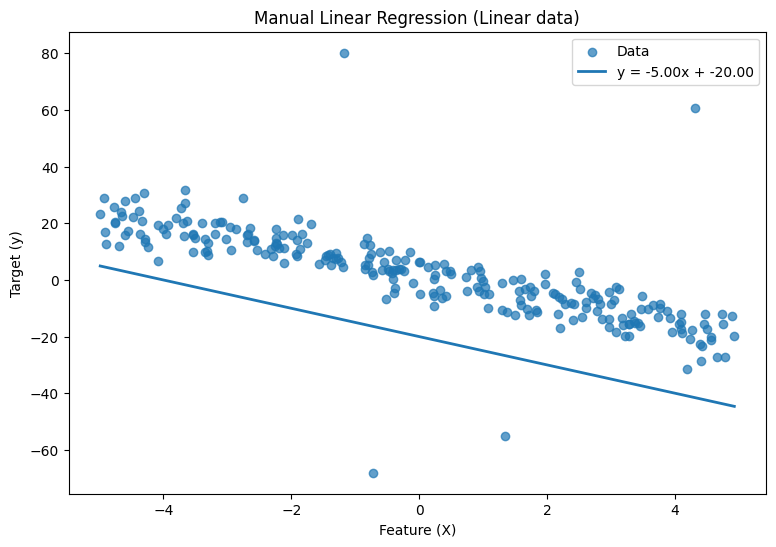

In [13]:
X_lin, y_lin = generate_regression_data(
    n_samples=250,
    n_features=1,
    mode='linear',
    noise=5.0,
    n_outliers=7,
    random_seed=STUDENT_NO,
    return_coef=False
)
lin_model_weights = [-5, -20]
evaluate_regression_model(y_lin, X_lin, model=lin_model_weights, print_results=True)
plot_regression_model(X_lin, y_lin, weights=[lin_model_weights[0]], intercept=lin_model_weights[1],
                      title="Manual Linear Regression (Linear data)")


----- 📈 Model Evaluation -----
 MAE: 33.1516
 MSE: 1379.6909
RMSE: 37.1442
  R2: -14.0738
------------------------------


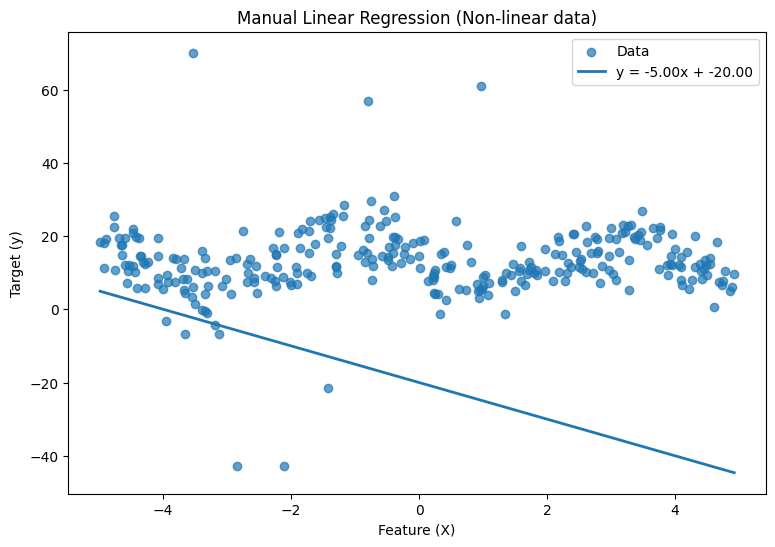

In [14]:
X_nonlin, y_nonlin = generate_regression_data(
    n_samples=300,
    n_features=1,
    mode='nonlinear',
    noise=5.0,
    n_outliers=10,
    random_seed=STUDENT_NO,
    return_coef=False
)
lin_model_weights = [-5, -20]
evaluate_regression_model(y_nonlin, X_nonlin, model=lin_model_weights, print_results=True)
plot_regression_model(X_nonlin, y_nonlin, weights=[lin_model_weights[0]], intercept=lin_model_weights[1],
                      title="Manual Linear Regression (Non-linear data)")

## 1.2. Tuning Linear Regression on non-linear data

Just change coefficients of the Linear model and observe changes in loss function

In [10]:
# Generating data
X_nonlin, y_nonlin = generate_regression_data(
    n_samples=300, 
    n_features=1, 
    mode='nonlinear', 
    noise=5.0, 
    n_outliers=10, 
    random_seed=STUDENT_NO, 
    return_coef=False
)

----- 📈 Model Evaluation -----
MAE      112.3467
MSE    20090.4955
RMSE     141.7409
R2     -2413.2631
-----------------------------


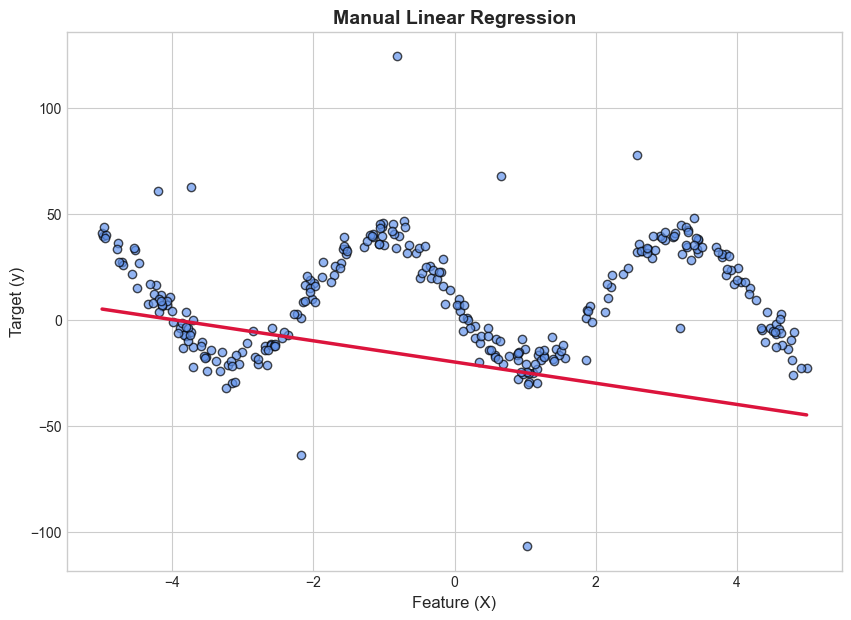

In [11]:
# Example of performing experiments
lin_model_weights = [-5, -20]
evaluate_regression_model(X_nonlin, y_nonlin, model=lin_model_weights, print_results=True)
plot_regression_model(X_nonlin, y_nonlin, 
                      weights=[lin_model_weights[0], ], 
                      intercept=lin_model_weights[1],
                      title='Manual Linear Regression')

## 1.3. Configuring various linear models from sklearn library

Try to configure hyperparameters of various linear regression models from sklearn

In [15]:
from sklearn.linear_model import LinearRegression, HuberRegressor, PoissonRegressor

### 1.3.1. Playing with `HuberRegressor`

----- 📈 Model Evaluation -----
 MAE: 4.9651
 MSE: 101.8491
RMSE: 10.0920
  R2: 0.5905
------------------------------


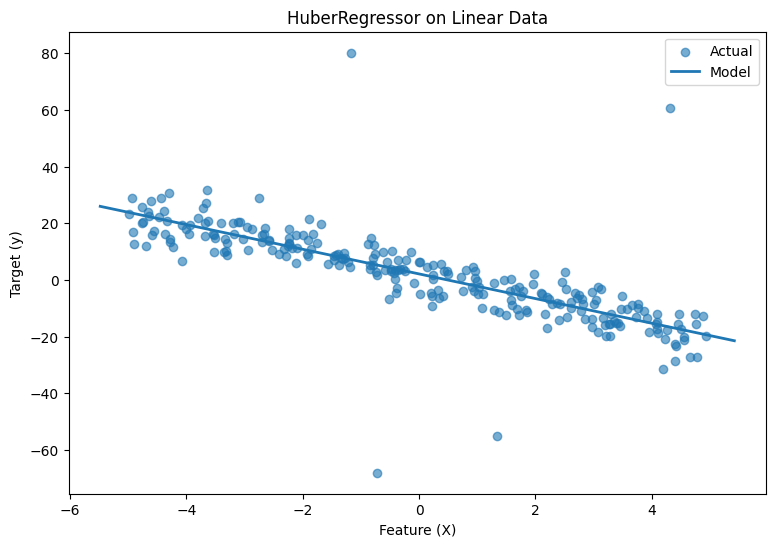

In [16]:
hub_model = HuberRegressor(
    epsilon=1.35,
    max_iter=100,
    alpha=1e-4,
    warm_start=False,
    fit_intercept=True,
    tol=1e-5
)
hub_model.fit(X_lin, y_lin)
evaluate_regression_model(y_lin, X_lin, model=hub_model, print_results=True)
plot_sklearn_regression(hub_model, X_lin.reshape(-1, 1), y_lin, title="HuberRegressor on Linear Data")


### 1.3.2. Playing with `PoissonRegressor`

----- 📈 Model Evaluation -----
 MAE: 5.1129
 MSE: 102.4805
RMSE: 10.1233
  R2: 0.5880
------------------------------


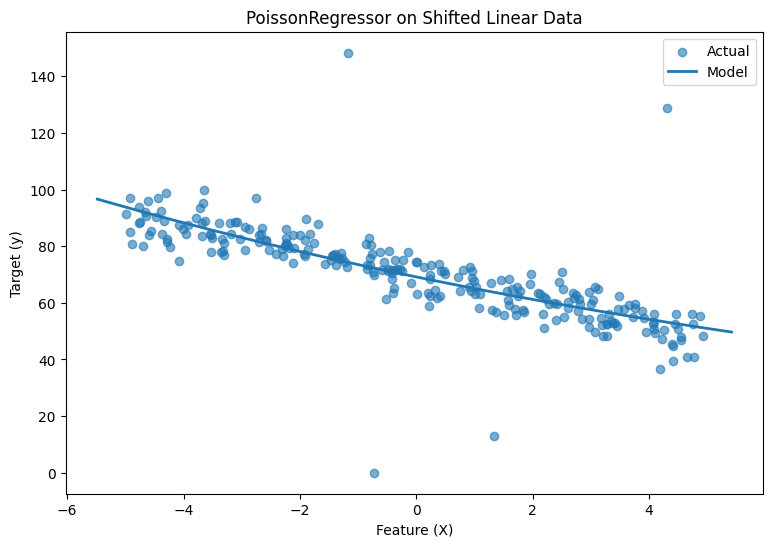

In [17]:
y_lin_shift = y_lin - y_lin.min() + 1e-6
pois_model = PoissonRegressor(
    alpha=1.0,
    fit_intercept=True,
    solver="lbfgs",
    max_iter=100,
    tol=1e-4,
    warm_start=True
)
pois_model.fit(X_lin, y_lin_shift)
evaluate_regression_model(y_lin_shift, X_lin, model=pois_model, print_results=True)
plot_sklearn_regression(pois_model, X_lin.reshape(-1, 1), y_lin_shift, title="PoissonRegressor on Shifted Linear Data")

## 1.4. Configure non-linear models from sklearn library

In [18]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR

### 1.4.1. Playing with `KNeighborsRegressor`

----- 📈 Model Evaluation -----
 MAE: 0.0000
 MSE: 0.0000
RMSE: 0.0000
  R2: 1.0000
------------------------------


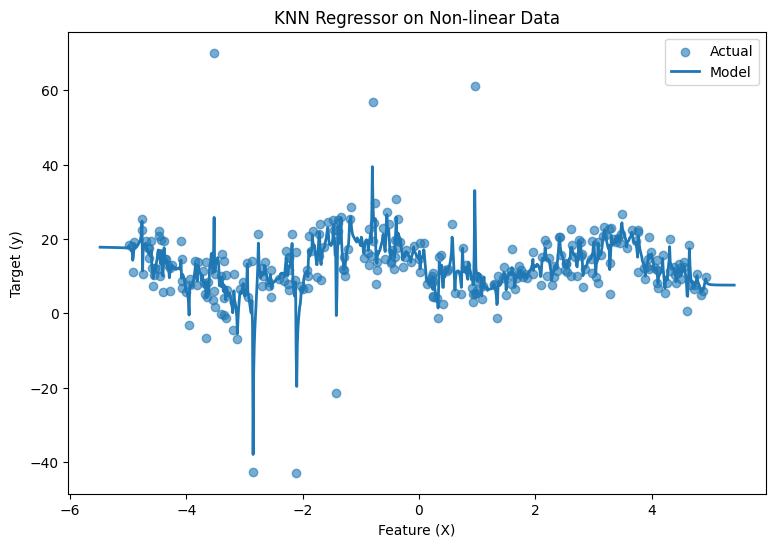

In [19]:
knn = KNeighborsRegressor(n_neighbors=7, weights='distance')
knn.fit(X_nonlin, y_nonlin)
evaluate_regression_model(y_nonlin, X_nonlin, model=knn, print_results=True)
plot_sklearn_regression(knn, X_nonlin, y_nonlin, title="KNN Regressor on Non-linear Data")

### 1.4.2. Playing with `RadiusNeighborsRegressor`

----- 📈 Model Evaluation -----
 MAE: 0.0000
 MSE: 0.0000
RMSE: 0.0000
  R2: 1.0000
------------------------------


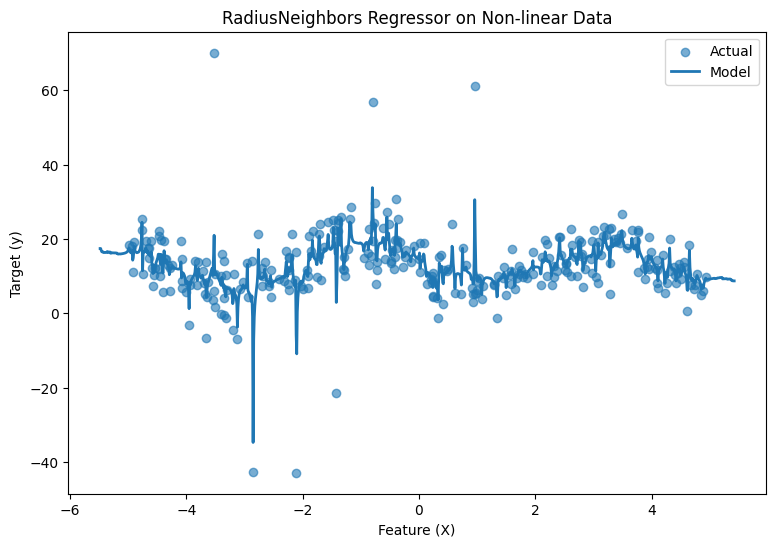

In [22]:
rnn = RadiusNeighborsRegressor(
    radius=0.9,
    weights='distance'
)
rnn.fit(X_nonlin, y_nonlin)

evaluate_regression_model(y_nonlin, X_nonlin, model=rnn, print_results=True)
plot_sklearn_regression(rnn, X_nonlin, y_nonlin,
                        title="RadiusNeighbors Regressor on Non-linear Data")

### 1.4.3. Playing with `DecisionTreeRegressor`

----- 📈 Model Evaluation -----
 MAE: 0.0000
 MSE: 0.0000
RMSE: 0.0000
  R2: 1.0000
------------------------------


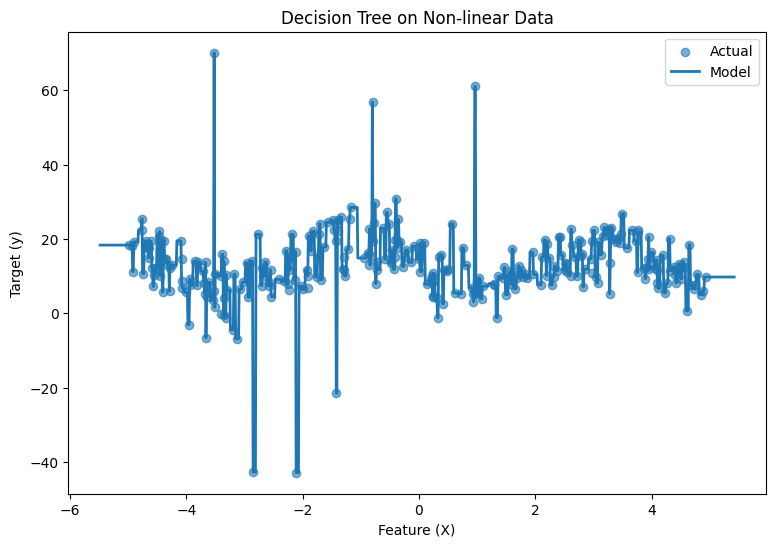

In [23]:
dt = DecisionTreeRegressor(random_state=STUDENT_NO)
dt.fit(X_nonlin, y_nonlin)
evaluate_regression_model(y_nonlin, X_nonlin, model=dt, print_results=True)
plot_sklearn_regression(dt, X_nonlin, y_nonlin, title="Decision Tree on Non-linear Data")

### 1.4.4. Playing with `AdaBoostRegressor`

----- 📈 Model Evaluation -----
 MAE: 6.5095
 MSE: 74.6213
RMSE: 8.6384
  R2: 0.1847
------------------------------


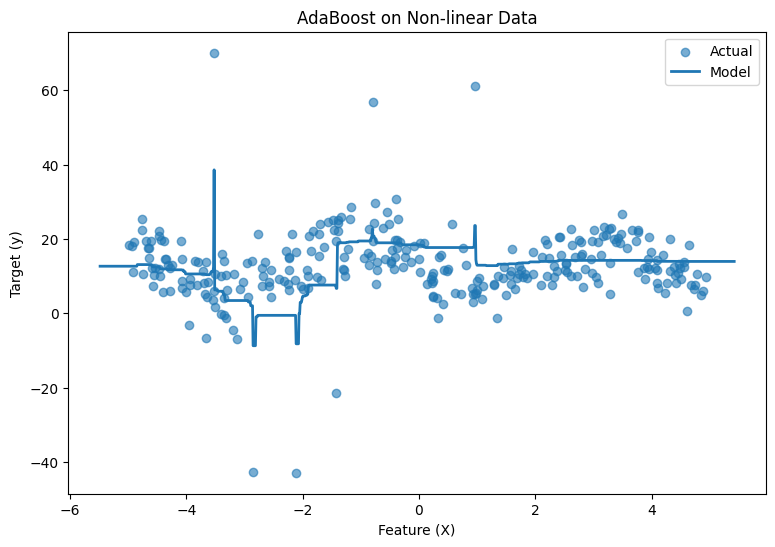

In [25]:
ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3, random_state=STUDENT_NO),
    n_estimators=150,
    learning_rate=0.1,
    random_state=STUDENT_NO
)

ada.fit(X_nonlin, y_nonlin)

evaluate_regression_model(y_nonlin, X_nonlin, model=ada, print_results=True)
plot_sklearn_regression(ada, X_nonlin, y_nonlin, title="AdaBoost on Non-linear Data")

### 1.4.5. Playing with `RandomForestRegressor`

----- 📈 Model Evaluation -----
 MAE: 2.4549
 MSE: 16.3230
RMSE: 4.0402
  R2: 0.8217
------------------------------


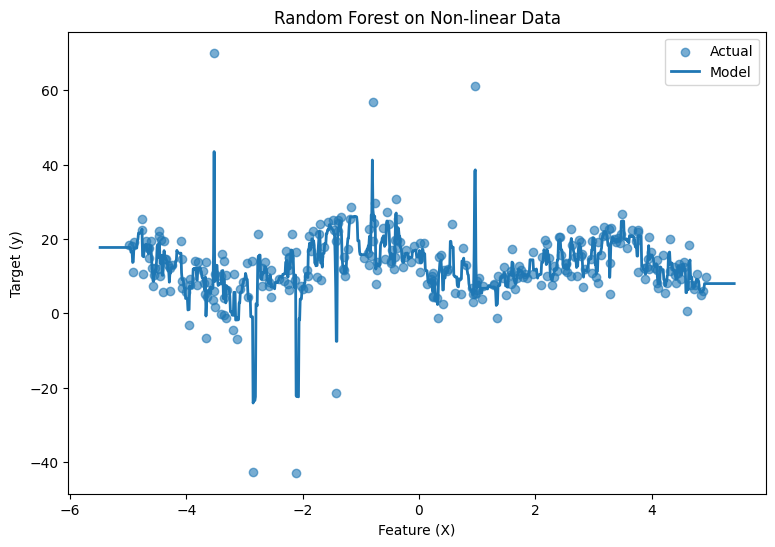

In [26]:
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=STUDENT_NO, n_jobs=-1)
rf.fit(X_nonlin, y_nonlin)
evaluate_regression_model(y_nonlin, X_nonlin, model=rf, print_results=True)
plot_sklearn_regression(rf, X_nonlin, y_nonlin, title="Random Forest on Non-linear Data")

### 1.4.6. Playing with `GradientBoostingRegressor`

----- 📈 Model Evaluation -----
 MAE: 3.3119
 MSE: 19.6029
RMSE: 4.4275
  R2: 0.7858
------------------------------


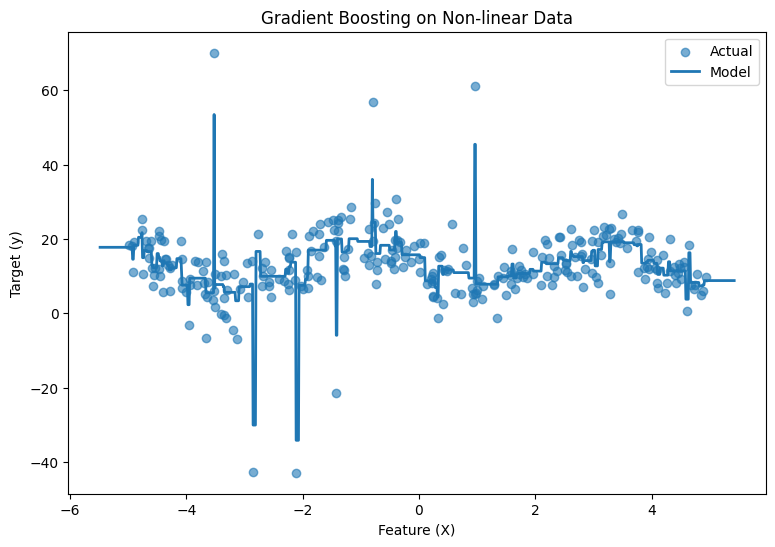

In [27]:
gbr = GradientBoostingRegressor(random_state=STUDENT_NO)
gbr.fit(X_nonlin, y_nonlin)
evaluate_regression_model(y_nonlin, X_nonlin, model=gbr, print_results=True)
plot_sklearn_regression(gbr, X_nonlin, y_nonlin, title="Gradient Boosting on Non-linear Data")

### 1.4.7. Playing with `VotingRegressor`

----- 📈 Model Evaluation -----
 MAE: 2.8055
 MSE: 15.9821
RMSE: 3.9978
  R2: 0.8254
------------------------------


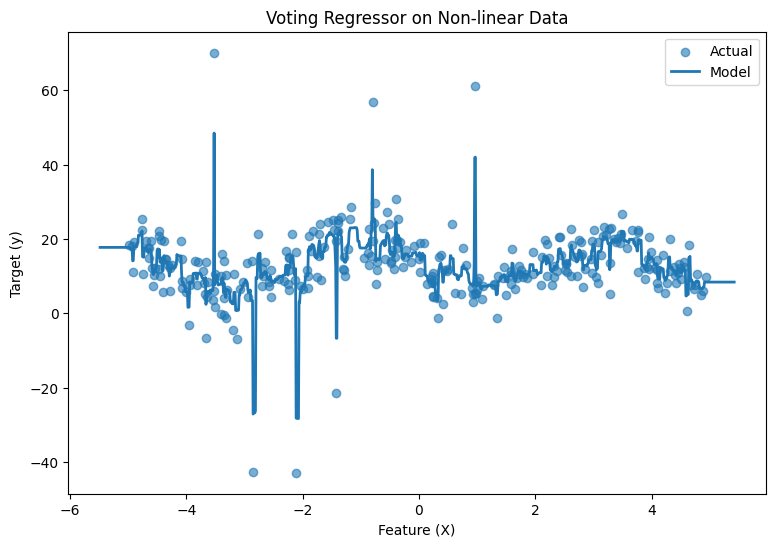

In [28]:
voter = VotingRegressor([('rf', rf), ('gbr', gbr)])
voter.fit(X_nonlin, y_nonlin)
evaluate_regression_model(y_nonlin, X_nonlin, model=voter, print_results=True)
plot_sklearn_regression(voter, X_nonlin, y_nonlin, title="Voting Regressor on Non-linear Data")

### 1.4.8. Playing with `SVR (Support Vector Regression)`

----- 📈 Model Evaluation -----
 MAE: 5.1376
 MSE: 78.4361
RMSE: 8.8564
  R2: 0.1430
------------------------------


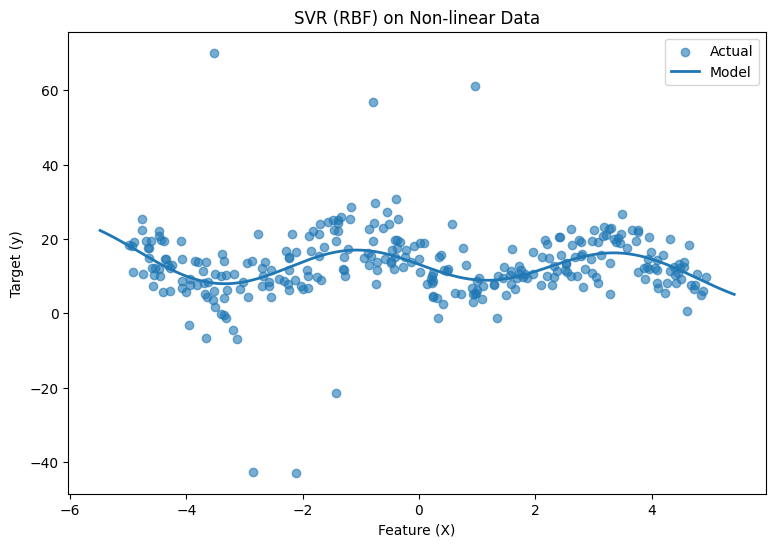

In [29]:
svr = SVR(C=10.0, epsilon=0.2, kernel='rbf', gamma='scale')
svr.fit(X_nonlin, y_nonlin)
evaluate_regression_model(y_nonlin, X_nonlin, model=svr, print_results=True)
plot_sklearn_regression(svr, X_nonlin, y_nonlin, title="SVR (RBF) on Non-linear Data")

# Section 2: experiments on real data

1. Choose any DataSet you like for you experiments (if you've chosen the same, consider that work must differ, otherwise both students will get 0 points for work).
2. Choose the top-3 methods (from `sklearn` library, or you can use other libraries (like `xgboost`) from the previous part.
2. Solve the regression problem in the same manner, as you used for.
    1. Load the data
    2. Do data visualization: correlation, feature distribution, etc.
    3. Do data analysis
    4. Do data correction
    5. Prepare data on usage with ML model: train, validation if necessary, test split; data convertion (to fix distribution or change data type to numeric); remove outliers.
    6. Tune hyperparameters of your model to get the best one.
    7. Train & test the final version of the model. Do conclusion.
3. Your main goal is tune hyperparameters of the chosen models.
4. Examples and template you can find in `ML_basic_course/lab_works/lab2/lab_2_example_plus_task.ipynb`. Or in [my GitHub repo's folder](https://github.com/VolDonets/ML_basics_course/tree/master/lab_works/lab_2)
5. Use that notebook as template, but remember your main goal is to tune hyperparameters of chosen models.

In [37]:
DATA_PATH = "1553768847-housing.csv"


In [38]:
df = None
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    print("Loaded dataframe shape:", df.shape)
    display(df.head())
else:
    print("⚠️ CSV not found. Please place 'housing.csv' (from Kaggle dataset) next to this notebook,")
    print("or update DATA_PATH above to its location. Skipping real-data steps will not stop Part I execution.")

Loaded dataframe shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


In [39]:
if df is not None:
    print("\nData Info:")
    display(df.info())
    possible_targets = ['median_house_value', 'MedHouseVal', 'MedianHouseValue']
    target_col = None
    for cand in possible_targets:
        if cand in df.columns:
            target_col = cand
            break
    if target_col is None:
        target_col = df.columns[-1]
        print(f"Target not found by name; using last column as target: {target_col}")
    else:
        print(f"Detected target column: {target_col}")

    print("\nMissing values per column:")
    display(df.isna().sum())



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


None

Detected target column: median_house_value

Missing values per column:


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

Numeric columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Categorical columns: ['ocean_proximity']


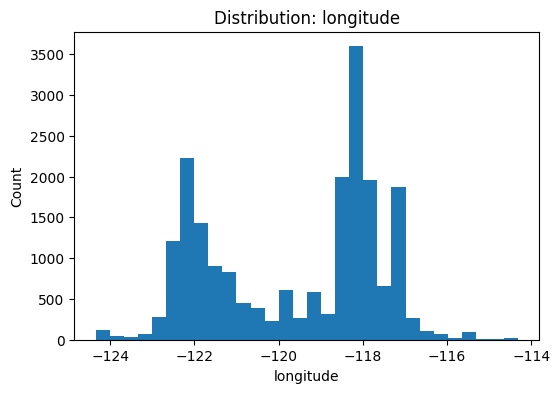

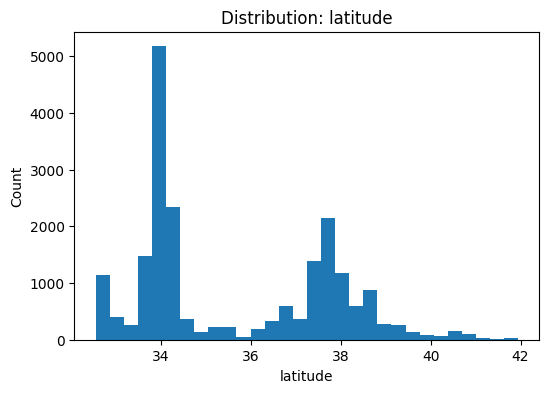

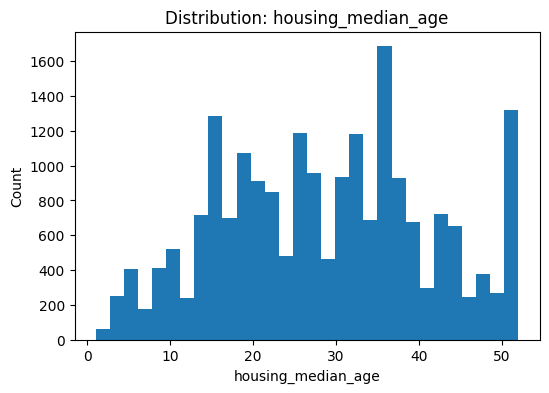

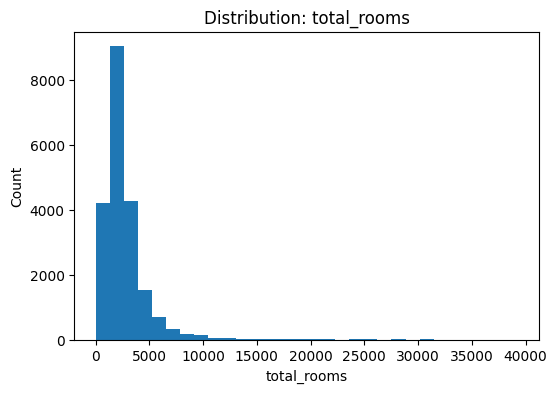

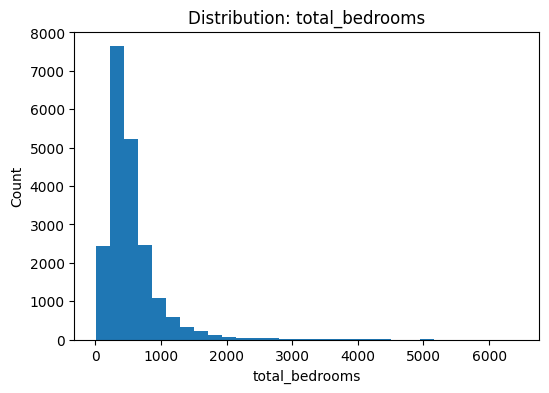

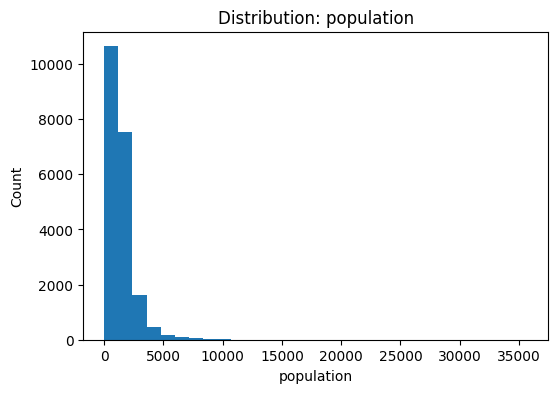

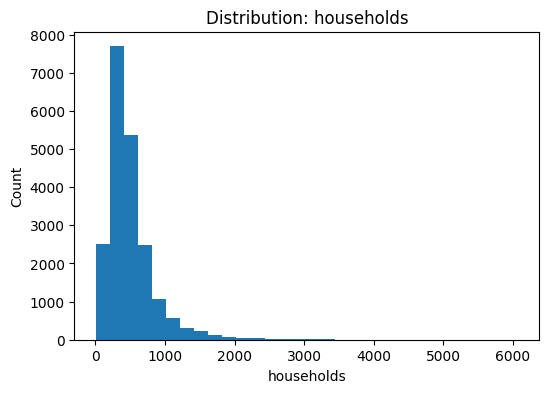

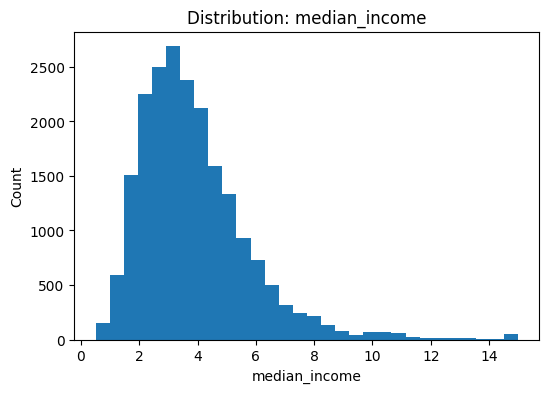

Correlation matrix (first 10x10 slice if large):


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [40]:
if df is not None:
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    print("Numeric columns:", num_cols)
    print("Categorical columns:", cat_cols)
    for col in num_cols[:8]:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.hist(df[col].dropna(), bins=30)
        ax.set_title(f"Distribution: {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.show()

    if len(num_cols) >= 2:
        corr = df[num_cols].corr(numeric_only=True)
        print("Correlation matrix (first 10x10 slice if large):")
        display(corr.iloc[:10, :10])


In [41]:
if df is not None:
    y = df[target_col].values
    X = df.drop(columns=[target_col])
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()
    numeric_preprocess = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('power', PowerTransformer(method='yeo-johnson', standardize=True)),
    ])
    categorical_preprocess = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_preprocess, num_cols),
        ('cat', categorical_preprocess, cat_cols)
    ])
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=STUDENT_NO
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.25, random_state=STUDENT_NO
    )
    print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

Shapes: (12384, 9) (4128, 9) (4128, 9)


In [45]:
if df is not None:
    rf_pipe = Pipeline(steps=[
        ('prep', preprocessor),
        ('model', RandomForestRegressor(random_state=STUDENT_NO, n_jobs=-1))
    ])
    rf_param = {
        'model__n_estimators': [200],
        'model__max_depth': [12, None],
    }
    rf_cv = GridSearchCV(rf_pipe, rf_param, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    rf_cv.fit(X_train, y_train)
    print("RF best params:", rf_cv.best_params_)
    print("RF best CV RMSE:", -rf_cv.best_score_)

    gbr_pipe = Pipeline(steps=[
        ('prep', preprocessor),
        ('model', GradientBoostingRegressor(random_state=STUDENT_NO))
    ])
    gbr_param = {
        'model__n_estimators': [200],
        'model__learning_rate': [0.05, 0.1]
    }
    gbr_cv = GridSearchCV(gbr_pipe, gbr_param, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    gbr_cv.fit(X_train, y_train)
    print("GBR best params:", gbr_cv.best_params_)
    print("GBR best CV RMSE:", -gbr_cv.best_score_)

    svr_pipe = Pipeline(steps=[
        ('prep', preprocessor),
        ('model', SVR())
    ])
    svr_param = {
        'model__C': [10, 30],
        'model__epsilon': [0.1],
        'model__kernel': ['rbf']
    }
    svr_cv = GridSearchCV(svr_pipe, svr_param, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    svr_cv.fit(X_train, y_train)
    print("SVR best params:", svr_cv.best_params_)
    print("SVR best CV RMSE:", -svr_cv.best_score_)


Fitting 2 folds for each of 2 candidates, totalling 4 fits
RF best params: {'model__max_depth': None, 'model__n_estimators': 200}
RF best CV RMSE: 55022.79152679021
Fitting 2 folds for each of 2 candidates, totalling 4 fits
GBR best params: {'model__learning_rate': 0.1, 'model__n_estimators': 200}
GBR best CV RMSE: 54547.33077696377
Fitting 2 folds for each of 2 candidates, totalling 4 fits
SVR best params: {'model__C': 30, 'model__epsilon': 0.1, 'model__kernel': 'rbf'}
SVR best CV RMSE: 113648.31296282698


In [47]:
if df is not None:
    models = {
        'RandomForest': rf_cv.best_estimator_,
        'GradientBoosting': gbr_cv.best_estimator_
    }
    try:
        models['SVR'] = svr_cv.best_estimator_
    except NameError:
        pass
    val_scores = {}
    for name, mdl in models.items():
        y_pred = mdl.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        mse  = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, y_pred)
        val_scores[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    print("Validation scores:")
    display(pd.DataFrame(val_scores).T.sort_values('RMSE'))

Validation scores:


,MAE,RMSE,R2
RandomForest,32922.438700,50566.435753,0.812780
GradientBoosting,35867.100968,52517.382291,0.798055
SVR,81231.516202,112368.154865,0.075485


Best model by validation RMSE: RandomForest

=== Final Test Metrics ===
MAE  : 33125.2910
RMSE : 51339.6111
R2   : 0.8040


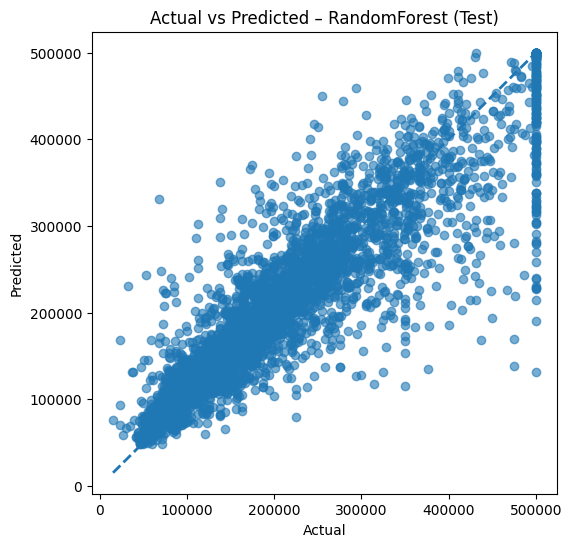

In [49]:
if df is not None:
    best_name = pd.DataFrame(val_scores).T['RMSE'].idxmin()
    best_model = models[best_name]
    print(f"Best model by validation RMSE: {best_name}")

    y_pred_test = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse  = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_pred_test)
    print("\n=== Final Test Metrics ===")
    print(f"MAE  : {test_mae:.4f}")
    print(f"RMSE : {test_rmse:.4f}")
    print(f"R2   : {test_r2:.4f}")

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_test, y_pred_test, alpha=0.6)
    lo = min(y_test.min(), y_pred_test.min())
    hi = max(y_test.max(), y_pred_test.max())
    ax.plot([lo, hi], [lo, hi], linestyle='--', linewidth=2.0)
    ax.set_title(f"Actual vs Predicted – {best_name} (Test)")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    plt.show()
